# Calling `R` libraries from Python

In this example we will explore the **Coral Reef Evaluation and Monitoring Project (CREMP)** data available in the **Gulf of Mexico Coastal Ocean Observing System (GCOOS)** ERDDAP server.

To access the server we will use the [`rerddap`](https://github.com/ropensci/rerddap) library and export the data to Python for easier plotting.

The first step is to load the `rpy2` extension that will allow us to use the `R` libraries.

In [1]:
%load_ext rpy2.ipython

The first line below has a `%%R` to make it an `R` cell. The code below specify the `GCOOS` server and fetches the data information for the [`cremp_fk_v2_1996`](http://gcoos4.tamu.edu:8080/erddap/tabledap/cremp_fk_v2_1996.html) dataset.

For more information on `rerddap` please see [https://rmendels.github.io/Using_rerddap.nb.html](https://rmendels.github.io/Using_rerddap.nb.html).

In [2]:
%%R

library('rerddap')

url <- 'http://gcoos4.tamu.edu:8080/erddap/'
data_info <- rerddap::info('cremp_fk_v2_1996', url=url)

data_info

<ERDDAP info> cremp_fk_v2_1996 
 Dimensions (range):  
 Variables:  
     averageNumberOfPoints: 
         Range: 407.0, 900.0 
     basisOfRecord: 
     bottomType: 
     class: 
     country: 
     datasetID: 
     datasetName: 
     depth: 
         Range: 3.0, 54.0 
         Units: m 
     dynamicProperties: 
     eventDate: 
     eventDateRemarks: 
     eventDateTimeZone: 
     family: 
     firstYear: 
         Range: 1996.0, 1996.0 
     genus: 
     geodeticDatum: 
     habitat: 
     higherInstitutionCode: 
     institutionCode: 
     kingdom: 
     lastYear: 
         Range: 2000.0, 2015.0 
     latitude: 
         Range: 24.4517, 25.2953 
         Units: degrees_north 
     locality: 
     longitude: 
         Range: -81.9195, -80.2087 
         Units: degrees_east 
     materialSampleID: 
     maximumDepthInMeters: 
         Range: 3.0, 54.0 
         Units: m 
     minimumDepthInMeters: 
         Range: 3.0, 54.0 
         Units: m 
     order: 
     ownerInstitutionCode: 

By inspecting the information above we can find the variables available in the dateset and use  the `tabledap` function to download them.

Note that the `%%R -o rdf` will export the `rdf` variable back to the Python workspace.

In [3]:
%%R -o rdf

fields <- c(
    'Samples',
    'depth',
    'time',
    'longitude',
    'latitude',
    'scientificName',
    'habitat',
    'genus',
    'quantificationValue'
)

rdf <- tabledap(
    data_info,
    fields=fields,
    url=url
)

Now we need to export the `R` `DataFrame` to a `pandas` objects and ensure that all numeric types are numbers and not strings.

In [4]:
import pandas as pd
from rpy2.robjects import pandas2ri


pandas2ri.activate()
df = pandas2ri.ri2py_dataframe(rdf)

cols = ['longitude', 'latitude', 'depth', 'quantificationValue']
df[cols] = df[cols].apply(pd.to_numeric)

df.head()

,Samples,depth,time,longitude,latitude,scientificName,habitat,genus,quantificationValue
2,0,6.0,1996-01-01T00:00:00Z,-80.3475,25.1736,Acropora cervicornis,Hard Bottom,Acropora,0.0
3,1,6.0,1996-01-01T00:00:00Z,-80.3475,25.1736,Acropora cervicornis,Hard Bottom,Acropora,0.0
4,2,6.0,1996-01-01T00:00:00Z,-80.3475,25.1736,Acropora cervicornis,Hard Bottom,Acropora,0.0
5,3,6.0,1996-01-01T00:00:00Z,-80.3475,25.1736,Acropora cervicornis,Hard Bottom,Acropora,0.0
6,4,9.0,1996-01-01T00:00:00Z,-80.3782,25.1201,Acropora cervicornis,Hard Bottom,Acropora,0.0


We can navigate to ERDDAP's [info page](http://gcoos4.tamu.edu:8080/erddap/info/cremp_fk_v2_1996/index.html) to find the variables description. Let's check what is `quantificationValue`:

    The is value of the derived information product, such as the numerical value for biomass. This term does not include units. Mean number of observed fish per species for 5 Minutes

We can see that `quantificationValue` has a lot of zero values,
let's remove that first to plot the data positions only where something was found.

In [5]:
# Filter invalid -999() and zero values.

cremp_1996 = df.loc[df['quantificationValue'] >=0]
cremp_1996.head()

,Samples,depth,time,longitude,latitude,scientificName,habitat,genus,quantificationValue
2,0,6.0,1996-01-01T00:00:00Z,-80.3475,25.1736,Acropora cervicornis,Hard Bottom,Acropora,0.0
3,1,6.0,1996-01-01T00:00:00Z,-80.3475,25.1736,Acropora cervicornis,Hard Bottom,Acropora,0.0
4,2,6.0,1996-01-01T00:00:00Z,-80.3475,25.1736,Acropora cervicornis,Hard Bottom,Acropora,0.0
5,3,6.0,1996-01-01T00:00:00Z,-80.3475,25.1736,Acropora cervicornis,Hard Bottom,Acropora,0.0
6,4,9.0,1996-01-01T00:00:00Z,-80.3782,25.1201,Acropora cervicornis,Hard Bottom,Acropora,0.0


What is the most abundant `genus`?

In [6]:
avg = cremp_1996.groupby('genus').mean()
avg

,Samples,depth,longitude,latitude,quantificationValue
genus,,,,,
,7873.785714,23.2375,-81.046667,24.768957,0.128309
Acropora,159.500000,23.2375,-81.046667,24.768957,0.006003
Agaricia,479.500000,23.2375,-81.046667,24.768957,0.000005
Cladocora,719.500000,23.2375,-81.046667,24.768958,0.000000
Colpophyllia,879.500000,23.2375,-81.046667,24.768958,0.005079
Dendrogyra,1039.500000,23.2375,-81.046667,24.768958,0.001327
Diadema,9999.500000,23.2375,-81.046667,24.768958,0.000000
Dichocoenia,1199.500000,23.2375,-81.046667,24.768958,0.000591
Diploria,1359.500000,23.2375,-81.046667,24.768958,0.001321


Let's check `quantificationValue` average by `genus`,

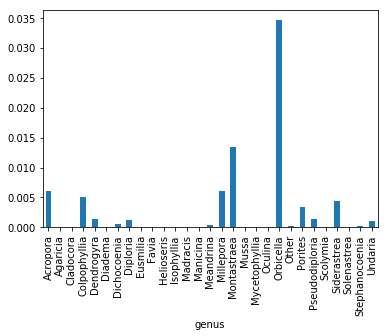

In [7]:
%matplotlib inline


ax = avg.iloc[1:]['quantificationValue'].plot(kind='bar')

and `habitat`.

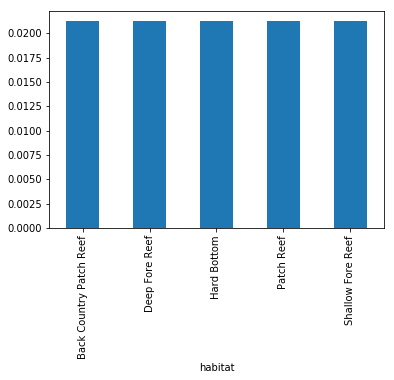

In [8]:
ax = cremp_1996.groupby('habitat').mean()['quantificationValue'].plot(kind='bar')

With a `pandas` `DataFrame` it is easy to group the data by location and count the `genus` occurrence.

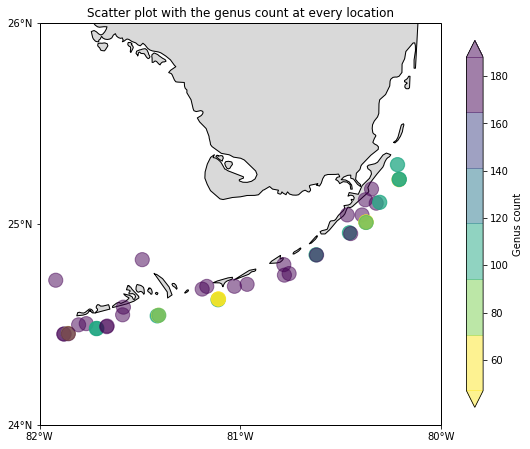

In [9]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib.pyplot as plt
import numpy as np


bbox = [-82, -80, 24, 26]
projection = ccrs.PlateCarree()

fig, ax = plt.subplots(
    figsize=(9, 9),
    subplot_kw=dict(projection=projection)
)

ax.set_extent(bbox)

land = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                    edgecolor='face',
                                    facecolor=[0.85]*3)
ax.add_feature(land, zorder=0)
ax.coastlines('10m', zorder=1)

ax.set_xticks(np.linspace(bbox[0], bbox[1], 3), crs=projection)
ax.set_yticks(np.linspace(bbox[2], bbox[3], 3), crs=projection)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

count = cremp_1996.groupby(['longitude', 'latitude']).count().reset_index()
c = ax.scatter(
    count['longitude'],
    count['latitude'],
    s=200,
    c=count['genus'],
    alpha=0.5,
    cmap=plt.cm.get_cmap('viridis_r', 6),
    zorder=3,
)
cbar = fig.colorbar(c, shrink=0.75, extend='both')
cbar.ax.set_ylabel('Genus count')
ax.set_title('Scatter plot with the genus count at every location');

This demonstration showed how mix `Python` and `R` to reduce developer time by taking advantage each language strengths.